In [2]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.stats import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [3]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1940, 2023), [5, 6, 7, 8, 9], -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_T = exp_T.da

In [4]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets(chunksize=100)
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
da_cee = exp_T.select_heat_wave_cluster(9, 5)
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, fill_holes=True, output_type="both")

100%|██████████| 51408/51408 [00:22<00:00, 2326.24it/s]


In [5]:
net, centers, labels = exp_s.compute_som(
    6,
    6,
    200,
    return_type=ADJUST_REALSPACE,
    train_kwargs=dict(train_algo="batch", epochs=1000),
)

n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]

2024-01-23 14:18:46.370 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2024-01-23 14:18:46.378 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2024-01-23 14:18:46.379 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file


In [6]:
this_define_blobs = partial(define_blobs_wind_speed, min_size=750)
refine_jets = partial(
    refine_jets_shortest_path, 
    compute_weights=compute_weights_wind_speed,
    jet_cutoff=2.4e3
)
jet_finder = JetFinder(
    preprocess=default_preprocess,
    define_blobs=this_define_blobs,
    refine_jets=refine_jets,
)
centers_all_jets = find_all_jets(jet_finder, xr.Dataset({'s': centers}), processes=1)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds = (
    xr.concat([xr.Dataset.from_dataframe(pd.DataFrame(centers_props[i])).rename(index='jet') for i in range(len(centers_props))], dim='center').assign_coords(center=np.arange(net.n_nodes))
)
bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
bmus_da.attrs["n_nodes"] = net.n_nodes
populations = (centers.ratios.values * len(da_s.time)).astype(int)
da_s_to_da_T = np.isin(da_s.time.values, da_T.time.values)

100%|██████████| 36/36 [00:00<00:00, 581.51it/s]


# Van Straaten SOM prediction

In [6]:
lags = [0, 1, 3, 5, 7, 15, 30]
timescales = [1, 7, 15, 30]
predictors = xr.DataArray(
    net.neighborhoods.distances[net.bmus],
    coords={'time': exp_s.time, 'center': np.arange(net.n_nodes)}
).sel(time=exp_s.time.dt.year < 2023)
da_cee = exp_T.select_heat_wave_cluster(9, 5).sel(time=exp_T.time.dt.year < 2023)
da_cee = da_cee.assign_coords(hourofyear=compute_hourofyear(da_cee))
da_cee = da_cee.expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)
for n_days in tqdm(timescales[1:]):
    for year in np.unique(da_cee.time.dt.year):
        year_mask = da_cee.time.dt.year == year
        da_cee.loc[year_mask, n_days] = window_smoothing(da_cee.loc[year_mask, 1], dim='hourofyear', winsize=4 * n_days, center=False).shift(time=- 4 * n_days + 1)

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [7]:
from sklearn.metrics import brier_score_loss
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
da_cee_targets = da_cee > da_cee.quantile(0.66, dim='time')
da_cee_targets = da_cee_targets.sel(time=JA_mask, timescale=[7, 15, 30])
base_pred = da_cee_targets.copy(data=np.zeros(da_cee_targets.shape, dtype=float))
base_pred = base_pred.assign_coords(
    f1_score=        ('timescale', np.zeros(len(base_pred.timescale))),
    roc_score=       ('timescale', np.zeros(len(base_pred.timescale))),
    accuracy=        ('timescale', np.zeros(len(base_pred.timescale))),
    brier_score_loss=('timescale', np.zeros(len(base_pred.timescale))),
)
X_base = (da_cee_targets.time.values - da_cee_targets.time.values[0]).astype('timedelta64[D]').astype(int)[:, None]
for timescale in da_cee_targets.timescale.values:
    y = da_cee_targets.loc[:, timescale].values
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2) 
    lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]
    y_pred = lr.predict(X_test)
    base_pred.loc[:, timescale] = lr.predict_proba(X_base)[:, 1]
    base_pred.roc_score.loc[timescale] = roc_auc_score(y_test, y_pred_prob)
    base_pred.brier_score_loss.loc[timescale] = brier_score_loss(y_test, y_pred_prob)
    base_pred.f1_score.loc[timescale] = f1_score(y_test, y_pred)
    base_pred.accuracy.loc[timescale] = balanced_accuracy_score(y_test, y_pred)

In [8]:
predictors = predictors.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True)
for lag in lags[1:]:
    for year in np.unique(predictors.time.dt.year):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            year_mask = predictors.time.dt.year == year
            predictors.loc[year_mask, :, lag] = predictors.loc[year_mask, :, lag].shift(time=lag).copy()
predictors = predictors[JA_mask]

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

targets = da_cee_targets - base_pred
full_pred = da_cee_targets.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True).astype(float)
full_pred[:] = 0
full_pred = full_pred.assign_coords(
    f1_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    roc_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    accuracy=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    brier_score_loss=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
)
coords = {
    'center': predictors.center.values,
    'target_timescale': full_pred.timescale.values,
    'lag': predictors.lag.values,
}
permutation_importances = xr.DataArray(np.zeros([len(c) for c in coords.values()]), coords=coords)
shap_importances = {}
for timescale, lag in tqdm(product(targets.timescale.values, lags), total=len(targets.timescale.values) * len(lags)):
    if timescale not in shap_importances:
        shap_importances[timescale] = {}
    # timescale of target, lag of driver 
    y_orig = da_cee_targets.loc[:, timescale]
    y = targets.loc[:, timescale]
    X = predictors.sel(lag=lag).values
    X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2) 
    rfr = RandomForestRegressor(max_depth=10, n_jobs=N_WORKERS).fit(X_train, y_train)
    y_pred_prob = rfr.predict(X_test) + base_pred.loc[:, timescale].values[idx_test]
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    full_pred.loc[:, timescale, lag] = rfr.predict(X) + base_pred.loc[:, timescale]
    full_pred.roc_score.loc[timescale, lag] = roc_auc_score(y_orig_test, y_pred_prob)
    full_pred.brier_score_loss.loc[timescale, lag] = brier_score_loss(y_orig_test, y_pred_prob)
    full_pred.f1_score.loc[timescale, lag] = f1_score(y_orig_test, y_pred)
    full_pred.accuracy.loc[timescale, lag] = balanced_accuracy_score(y_orig_test, y_pred)
    r = permutation_importance(rfr, X_test, y_test, n_repeats=30, random_state=0, n_jobs=N_WORKERS)
    r = r.importances_mean
    permutation_importances.loc[:, timescale, lag] = r
    X = pd.DataFrame(X, index=predictors.time.values, columns=predictors.center.values)
    shap_values = shap.TreeExplainer(rfr, X.iloc[np.random.randint(0, X.shape[0], size=200), :])(X, check_additivity=False)
    shap_importances[timescale][lag] = shap_values

100%|██████████| 21/21 [42:35<00:00, 121.71s/it]00]        


In [31]:
shap_abs_mean_importances = permutation_importances.copy()
shap_mean_importances = permutation_importances.copy()
shap_correlations = permutation_importances.copy()
for timescale, lag in product(targets.timescale.values, lags):
    shap_values = shap_importances[timescale][lag]
    shap_abs_mean = shap_values.abs.mean(axis=0).values
    shap_abs_mean_importances.loc[:, timescale, lag] = shap_abs_mean
    shap_mean = shap_values.mean(axis=0).values
    shap_mean_importances.loc[:, timescale, lag] = shap_mean
    importance_correlation = np.diag(np.corrcoef(shap_values.values, shap_values.data, rowvar=False)[shap_values.shape[1]:, :shap_values.shape[1]])
    shap_correlations.loc[:, timescale, lag] = importance_correlation

In [ ]:
full_pred.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_full_pred.nc')
permutation_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_permutation_importances.nc')
save_pickle(shap_importances, '/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_importances.pkl')
shap_abs_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_abs_mean_importances.nc')
shap_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_mean_importances.nc')
shap_correlations.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_correlations.nc')

In [35]:
full_pred = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_full_pred.nc')
permutation_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_permutation_importances.nc')
shap_importances = load_pickle('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_importances.pkl')
shap_abs_mean_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_abs_mean_importances.nc')
shap_correlations = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_correlations.nc')

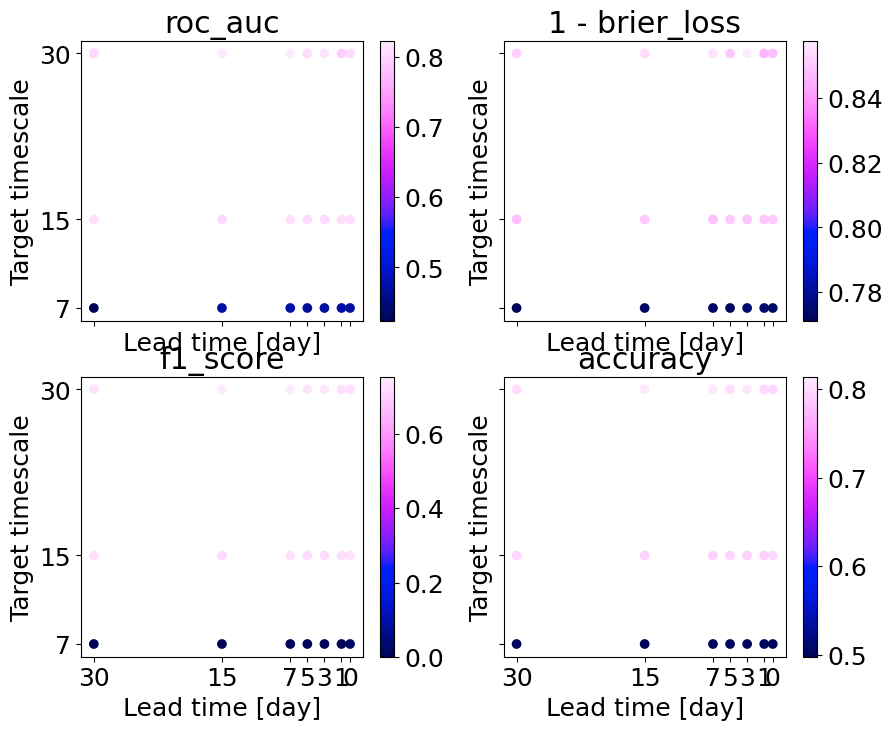

In [36]:
x = full_pred.lag.values
y = full_pred.timescale.values
scores = {
    'roc_auc': full_pred.roc_score.values,
    '1 - brier_loss': 1 - full_pred.brier_score_loss.values,
    'f1_score': full_pred.f1_score.values,
    'accuracy': full_pred.accuracy.values,
}
cmap = colormaps.cet_l_bmw1
fig, axes = plt.subplots(2, len(scores) // 2, figsize=(10, 8), sharex='all', sharey='all')
for (scorename, scores_), ax in zip(scores.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=scores_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel('Lead time [day]')
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel('Target timescale')
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)
ax.invert_xaxis()

invalid value encountered in sqrt


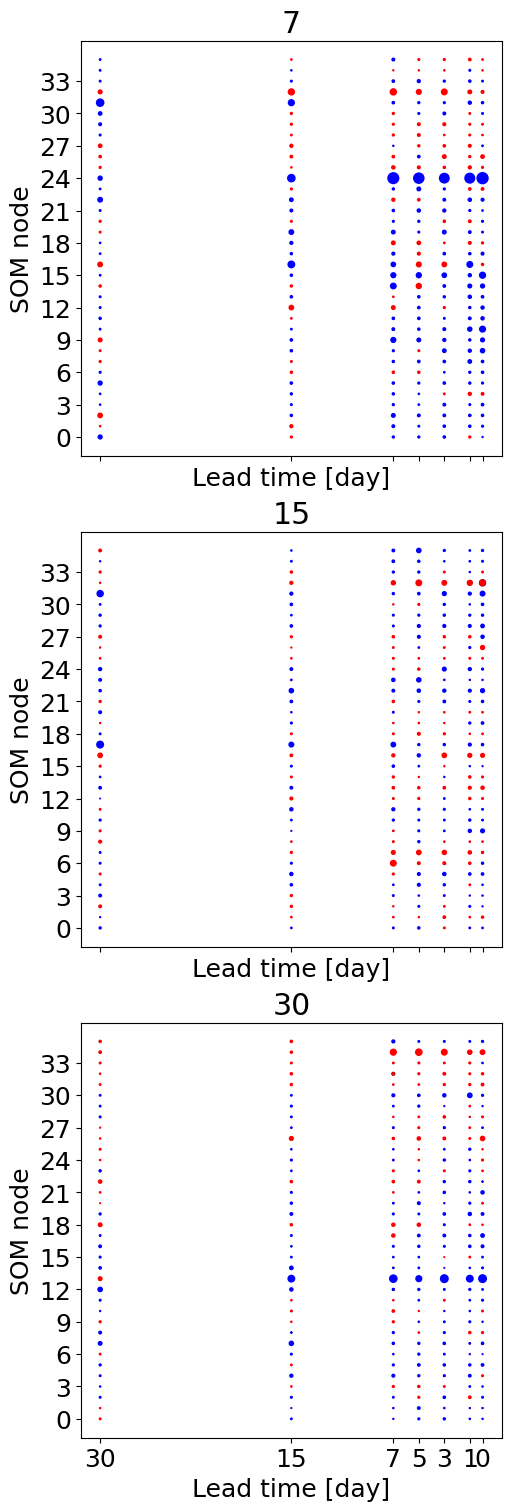

In [37]:
x = shap_abs_mean_importances.lag.values
y = shap_abs_mean_importances.center.values
fig, axes = plt.subplots(3, 1, figsize=(5, 15), constrained_layout=True, sharey='all', sharex='all')
target_timescales = shap_abs_mean_importances.target_timescale.values
for target_timescale, ax in zip(target_timescales, axes):
    s1 = permutation_importances.loc[:, target_timescale, :].values
    s2 = shap_abs_mean_importances.loc[:, target_timescale, :].values
    s3 = shap_correlations.loc[:, target_timescale, :].values
    ax.scatter(*np.meshgrid(x, y), s=s1 * 2000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2 * 2000, c=np.sign(s3), cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Lead time [day]')
    ax.set_xticks(np.unique(x))
    ax.set_ylabel('SOM node')
    ax.set_yticks(np.unique(y)[::3])
    ax.set_title(f'{target_timescale}')
ax.invert_xaxis()

# Relative time series

In [7]:
predictors = xr.DataArray(
    mask,
    coords={'time': exp_s.time, 'center': np.arange(net.n_nodes)}
).sel(time=exp_s.time.dt.year < 2023)
da_cee = exp_T.select_heat_wave_cluster(9, 5)
da_cee = da_cee.sel(time=da_cee.time.dt.year < 2023)

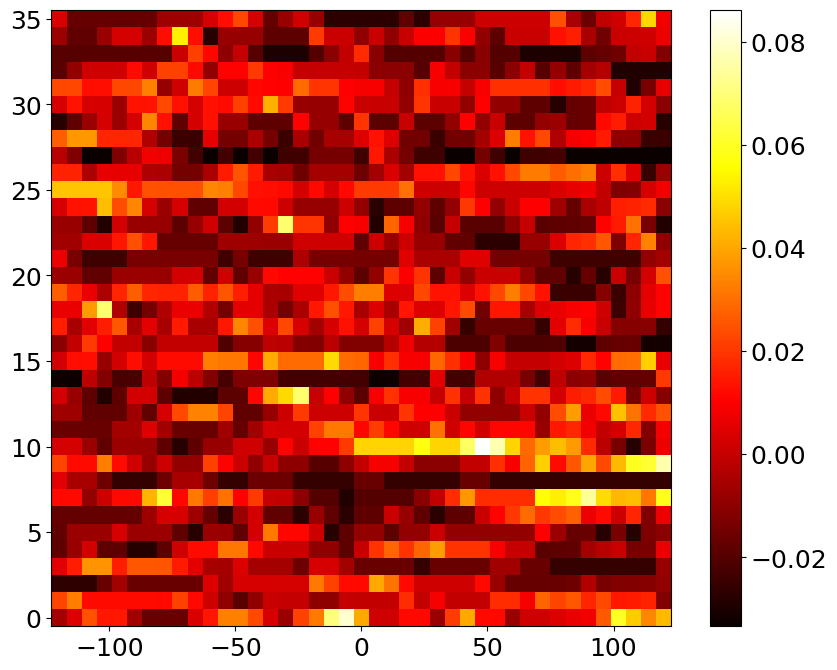

In [15]:
days_before = 5
predictors_masked = mask_from_t(
    da_cee, predictors.astype(float), q=.9,
    time_before=pd.Timedelta(days_before, 'D')
)
predictors_masked = predictors_masked.sel(time_around_beg=slice(pd.Timedelta(-24 * days_before, 'h'), pd.Timedelta(24 * days_before, 'h')))
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dt = (exp_s.time.values[1] - exp_s.time.values[0]).astype('timedelta64[h]')
x = predictors_masked.time_around_beg.values.astype('timedelta64[h]')
y = predictors_masked.center.values
freq_anoms = predictors_masked.mean(dim='heat_wave').values.T
freq_anoms = freq_anoms - predictors.mean(dim='time').values[:, None]
im = ax.pcolormesh(
    x.astype(int), 
    y, 
    freq_anoms, 
    shading='nearest',
    cmap='hot'
)
plt.colorbar(im)

In [33]:
np.set_printoptions(precision=3)
argmax = np.argmax(freq_anoms, axis=0)
amax = np.amax(freq_anoms, axis=0)
print(np.asarray([argmax, amax, x.astype(int)]).T)

[[  25.       0.045 -120.   ]
 [  25.       0.045 -114.   ]
 [  25.       0.045 -108.   ]
 [  18.       0.069 -102.   ]
 [  25.       0.035  -96.   ]
 [  24.       0.034  -90.   ]
 [   7.       0.043  -84.   ]
 [   7.       0.062  -78.   ]
 [  34.       0.053  -72.   ]
 [  12.       0.033  -66.   ]
 [  25.       0.034  -60.   ]
 [   0.       0.033  -54.   ]
 [  17.       0.034  -48.   ]
 [  17.       0.024  -42.   ]
 [  30.       0.041  -36.   ]
 [  23.       0.068  -30.   ]
 [  13.       0.068  -24.   ]
 [   2.       0.032  -18.   ]
 [   0.       0.07   -12.   ]
 [   0.       0.08    -6.   ]
 [  10.       0.048    0.   ]
 [  10.       0.048    6.   ]
 [  10.       0.048   12.   ]
 [  10.       0.048   18.   ]
 [  10.       0.058   24.   ]
 [  10.       0.048   30.   ]
 [  10.       0.048   36.   ]
 [  10.       0.067   42.   ]
 [  10.       0.086   48.   ]
 [  10.       0.077   54.   ]
 [  10.       0.048   60.   ]
 [  26.       0.032   66.   ]
 [   7.       0.056   72.   ]
 [   7.   

# On a yearly basis

In [40]:
def get_frequency_anomaly(hs_da: xr.DataArray, labels: xr.DataArray | NDArray, year: int | Sequence = YEARSPL_EXT, len_thresh: int = 1): 
    if isinstance(year, int):
        year = [year]
    mask = labels_to_mask(labels)
    mask_none = mask[:, 0]
    mask = mask[:, 1:]
    mask_thisyear = labels.time.dt.year.isin(year)
    unique_labels, counts = np.unique(labels.sel(time=mask_thisyear), return_counts=True)
    thisyear_pops = np.zeros(mask.shape[1], dtype=int)
    thisyear_pops[unique_labels[1:] - 1] = counts[1:]
    thisyear_probas = thisyear_pops / np.sum(thisyear_pops)
    hs_da = hs_da.sel(time=mask_thisyear)
    conditional_probas = (
        np.sum(
            (hs_da > len_thresh).values[:, None] & mask[mask_thisyear.values], axis=0
        )
        / np.sum((hs_da > len_thresh).values, axis=0)
    )
    return conditional_probas - thisyear_probas[:]

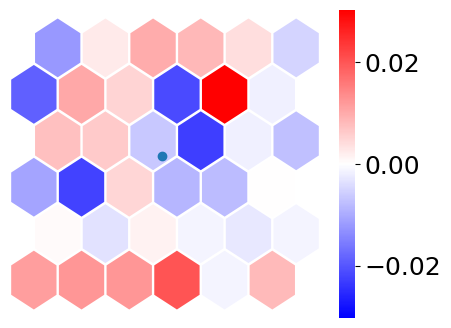

In [43]:
to_plot = get_frequency_anomaly(hs_da, labels[da_s_to_da_T])
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(- np.amax(np.abs(to_plot)), np.amax(np.abs(to_plot)))
}
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    draw_cbar=True,
    **kwargs,
)
x, y = net.neighborhoods.coordinates[bmus_da.loc[np.concatenate(heat_waves_ts)].values].mean(axis=0)
ax.scatter(x, y)
plt.show()

## Events basis

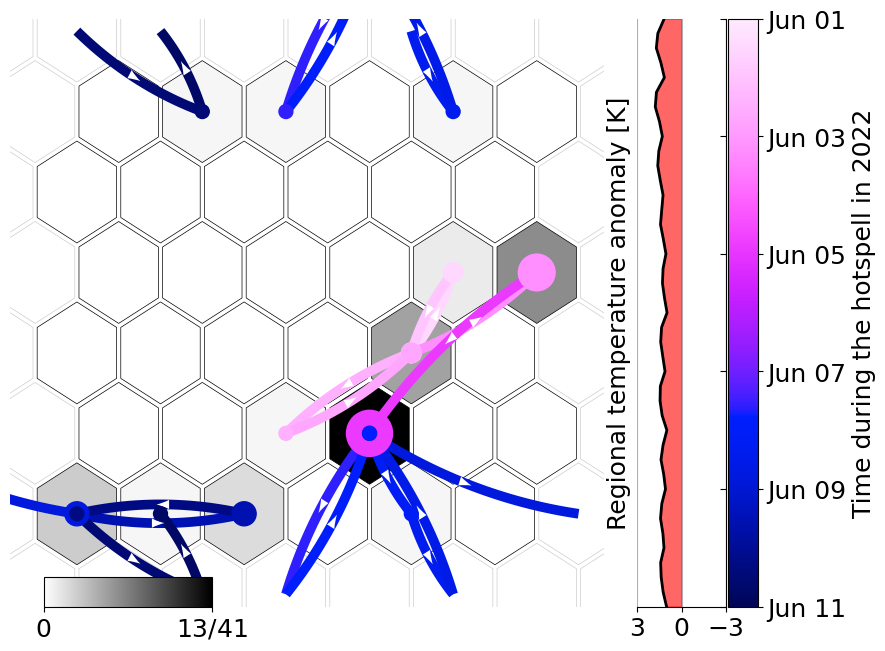

In [9]:
season = da_cee.sel(time=(da_cee.time.dt.year == 2022) & (da_cee.time.dt.month == 8)).time.values
heat_wave = heat_waves_ts[-4]
fig, ax, cbar = plt_traj_hotspell(heat_wave, bmus_da, da_cee)
fig.savefig(f'{FIGURES}/som_props/hotspell_2022.png', dpi=300, bbox_inches='tight')

# Max. residence time comparison

In [40]:
heat_waves_stays = {'longest_stay': [], 'ref_distrib': [], 'significant': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(bmus_da.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    from scipy.stats import mode
    these_bmus = bmus_da.values[indices]
    counts = mode(np.cumsum(np.diff(these_bmus, axis=1) != 0, axis=1), axis=1)[1]
    these_bmus = bmus_da.loc[heat_waves_ts[-2]].values
    heat_wave_longest_stay = mode(np.cumsum(np.diff(these_bmus) != 0))[1]
    heat_waves_stays['longest_stay'].append(heat_wave_longest_stay)
    heat_waves_stays['ref_distrib'].append(np.sort(counts))
    heat_waves_stays['significant'].append(heat_wave_longest_stay >= np.quantile(counts, 0.95))
np.where(heat_waves_stays['significant'])[0]

array([ 0,  1,  2,  3, 12, 20, 24, 25, 26, 27, 32, 35])

In [41]:
these_bmus

array([16, 16, 16,  4,  4,  8,  8,  8,  5, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 11, 11, 11, 22, 22, 22, 22, 22, 22, 22, 22, 22,  6,  6,
        6, 24, 18, 18])

# More or less jumps ?

In [6]:
da_cee.resample(time='1Y').mean().values

array([-0.07726, -0.28257, -0.28039, -0.30064, -0.32121, -0.11819,
       -0.17566, -0.10307, -0.35808, -0.47515, -0.30962, -0.13322,
       -0.06977,  0.13141, -0.07675, -0.20095, -0.58205, -0.11424,
       -0.42638, -0.1988 , -0.04774, -0.06284, -0.69428, -0.43103,
       -0.49582, -0.5529 , -0.1985 , -0.25963, -0.64634, -0.53744,
       -0.42608, -0.44065, -0.2085 , -0.26015, -0.44736, -0.24914,
       -0.45048, -0.29568, -0.7737 , -0.38379, -0.33231, -0.0815 ,
       -0.57439, -0.3116 , -0.24902, -0.27355, -0.39185, -0.17738,
        0.26956,  0.26984,  0.1516 ,  0.06916, -0.64732, -0.26844,
       -0.11319,  0.32371, -0.2148 , -0.00393,  0.58646,  0.32105,
        0.14415,  0.38718,  0.37341,  0.7244 ,  0.39297,  0.54505,
        0.68418,  0.57326,  0.59763,  0.33328,  0.99404,  0.5312 ,
        1.06274,  0.70795,  0.70364,  0.48182,  1.16987,  0.62356,
        0.82211,  0.84845,  0.93608,  1.26219,  1.15319], dtype=float32)

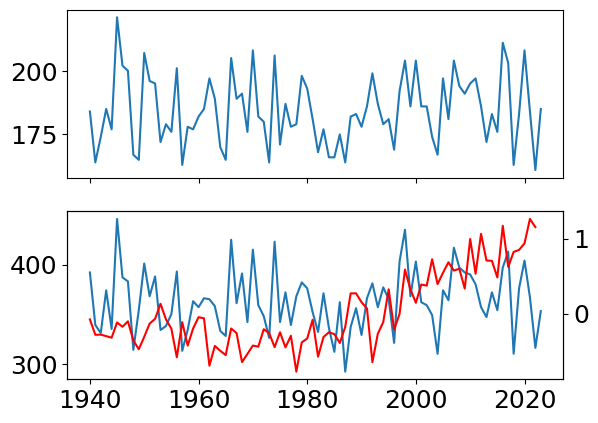

In [7]:
dist_mat = net.neighborhoods.distances
years = np.unique(bmus_da.time.dt.year.values)
jumps_per_year = []
distance_per_year = []
for year in years:
    nodes = bmus_da.sel(time=bmus_da.time.dt.year == year).values
    jumps = np.diag(dist_mat[nodes[:-1], :][:, nodes[1:]])
    jumps_per_year.append(np.sum(jumps > 0))
    distance_per_year.append(np.sum(jumps))
fig, axes = plt.subplots(2, 1, sharex='all')
axes[0].plot(years, jumps_per_year)
axes[1].plot(years, distance_per_year)
axes[1].twinx().plot(years[:-1], da_cee.resample(time='1Y').mean().values, color='red')

In [8]:
jumps = bmus_da[:-1].copy(data=dist_mat[bmus_da[:-1], bmus_da[1:]])

In [ ]:
heat_waves_jumps = {'distance': [], 'ref_distrib': [], 'significative': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(bmus_da.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    ref_distrib = np.sum(jumps.values[indices], axis=1)
    compare_against = np.quantile(ref_distrib, q=0.01)
    heat_wave_distance = np.sum(jumps.loc[heat_wave].values)
    heat_waves_jumps['distance'].append(heat_wave_distance)
    heat_waves_jumps['ref_distrib'].append(np.sort(ref_distrib))
    heat_waves_jumps['significative'].append(heat_wave_distance <= compare_against)
np.where(heat_waves_jumps['significative'])[0]

array([31])

In [ ]:
yearbreaks = np.sum(bmus_da.time.dt.year == bmus_da.time.dt.year[0]).item()
possible_tuples = [
    (i, j) for i, j in product(range(net.n_nodes), range(net.n_nodes))
]
possible_tuples = np.asarray(possible_tuples, dtype='i,i')
indices = [i for n in range(len(np.unique(bmus_da.time.dt.year))) for i in range(n * yearbreaks, (n + 1) * yearbreaks - 1)]
transitions = np.zeros(len(da_s.time), dtype='i, i')
transitions[indices] = [(net.bmus[i], net.bmus[i + 1]) for i in indices]
transition_masks = transitions[:, None] == possible_tuples[None, :]
unique_transitions, counts = np.unique(transitions, return_counts=True)
trans_mat = np.zeros((net.n_nodes, net.n_nodes))
trans_mat[unique_transitions['f0'], unique_transitions['f1']] = counts
sort_order = np.argsort(counts)[::-1][:50]
sort_order_1 = [i for i in sort_order if unique_transitions[i][0] == unique_transitions[i][1]]
sort_order_2 = [i for i in sort_order if unique_transitions[i][0] != unique_transitions[i][1]]

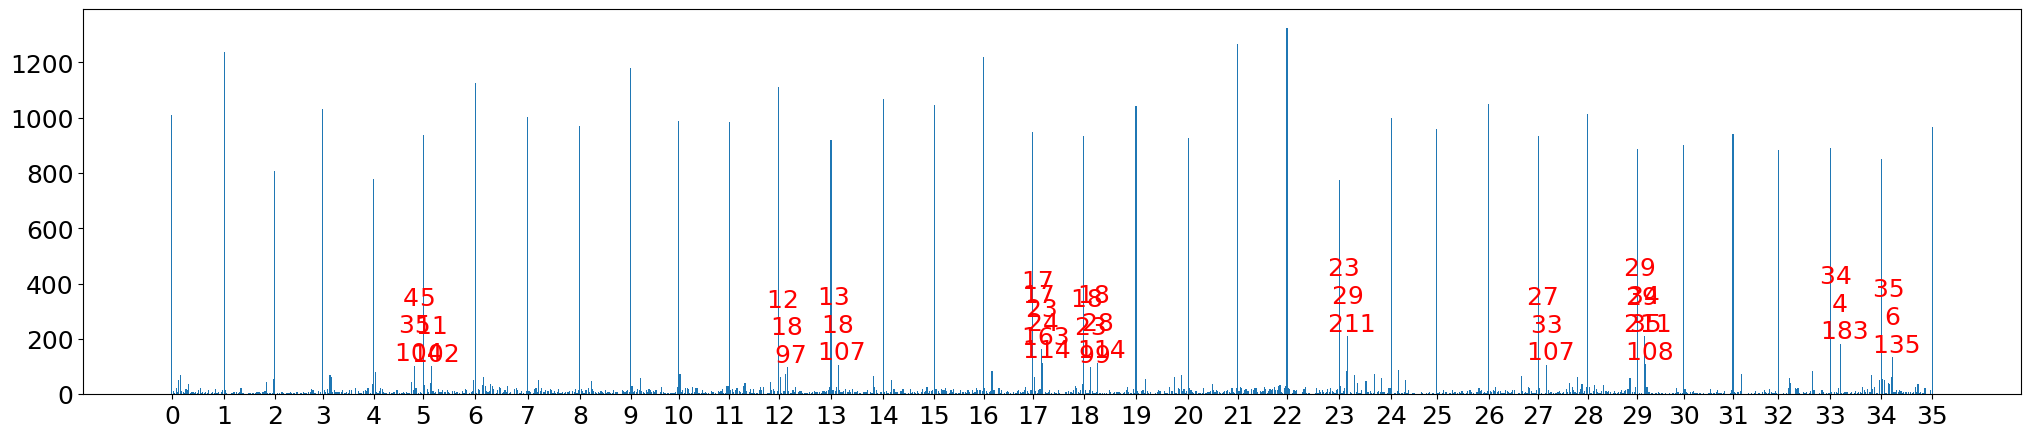

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(len(counts)), counts)
ax.set_xticks(sort_order_1, unique_transitions['f0'][sort_order_1])
for i in sort_order_2:
    xy = (i, counts[i])
    xytext = (i, counts[i])
    plt.annotate(f'{unique_transitions[i][0]} \n {unique_transitions[i][1]} \n {counts[i]}', xy=xy, xytext=xytext, ha='center', va='bottom', color='red')

In [ ]:
unique_transitions_heat_waves, counts_heat_waves = np.unique(transitions[np.where(np.isin(bmus_da.time.values, np.concatenate(heat_waves_ts)))[0]], return_counts=True)

In [ ]:
all_to_hs = np.isin(unique_transitions, unique_transitions_heat_waves)
counts_heat_waves - counts[all_to_hs]
# counts_heat_waves

array([ -984,   -51,   -67,   -14,   -37,    -6,   -19,    -6,    -3,
        -988,   -67,   -60,   -15,    -8,    -5,   -15,   -12,   -15,
         -22,  -775,    -9,   -11,    -5,  -929,   -31,  -101,   -12,
         -17,   -13,   -10,   -50, -1071,   -30,   -59,   -28,   -10,
          -7,   -11,   -29,   -17,   -13,    -6,   -18,   -22,   -13,
         -12,  -987,    -8,    -4,   -11,   -19,   -19,  -963,   -10,
         -16, -1129,   -28,   -57,   -11,   -12,   -12,  -957,   -16,
         -26,    -9,   -21,   -22,    -9,   -16,   -27,  -963,   -19,
         -14,   -22,   -27,    -3,   -17,    -5,   -16,   -25,   -42,
         -12, -1071,   -59,    -5,   -10,   -73,   -91,   -25,    -6,
          -5,   -15,   -24,  -905,  -102,   -16,    -9,    -7,    -6,
         -63,    -7, -1046,    -4,   -49,    -6,   -10,   -12,   -13,
       -1030,   -16,   -15,   -17,    -8,    -6,    -5,   -20,   -14,
       -1175,   -19,   -12,   -13,    -3,    -7,    -9,   -23,    -3,
         -11,  -910,

In [13]:
bmus_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/bmus_da.nc')
np.save('/storage/homefs/hb22g102/persistent-extremes-era5/results/heat_waves_cee.npy', heat_waves)

# Whole period, attribution and conditional probas

In [ ]:
num_lags = 3 * 4
hotspells = get_hotspells_v2(lag_behind=num_lags)[0]
clustered_hotspells = {region: [[] for _ in range(net.n_nodes)] for region in REGIONS}
unattributed = {region: [] for region in REGIONS}
for k, region in enumerate(REGIONS):
    for j, hotspell in enumerate(hotspells[k]):
        try:
            unique, counts = np.unique(labels.loc[hotspell[:2 * num_lags]], return_counts=True)
            remove_zero = unique != 0
            unique = unique[remove_zero] - 1
            counts = counts[remove_zero]
            where = np.argmax(counts)
            clustered_hotspells[region][int(unique[where])].append((len(hotspell), j))
        except KeyError:
            unattributed[region].append((len(hotspell), j))
            

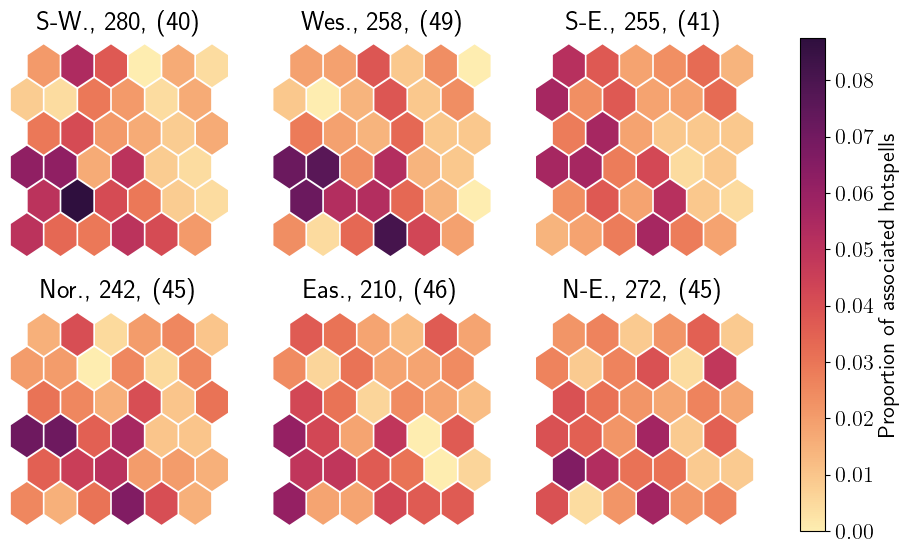

In [ ]:

to_plot = np.asarray([[len(cluhs) for cluhs in list_of_nodes] for list_of_nodes in clustered_hotspells.values()])
denominator = np.asarray([len(hs) for hs in hotspells]) - np.asarray([len(unat) for unat in unattributed.values()])
to_plot = to_plot / denominator[:, None]
kwargs = {
    "cmap": colormaps.matter,
    "norm": Normalize(0, np.amax(to_plot))
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, tplt) in enumerate(zip(REGIONS, to_plot)):
    ax = axes[k]
    fig, ax = net.plot_on_map(
        tplt,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs,
    )
    ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Proportion of associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


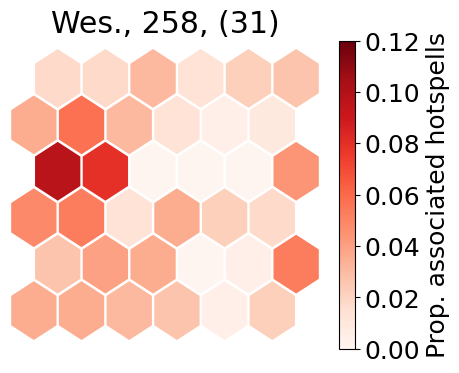

In [ ]:
kwargs = {
    "cmap": "Reds",
    "norm": Normalize(0, 0.12),
}
fig, ax = plt.subplots(figsize=(5, 4))
region = "West"
k = 1
list_of_nodes = clustered_hotspells[region]
tplt = np.asarray([len(l) for l in list_of_nodes])
fig, ax = net.plot_on_map(
    tplt / (len(hotspells[k]) - len(unattributed[region])),
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Prop. associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


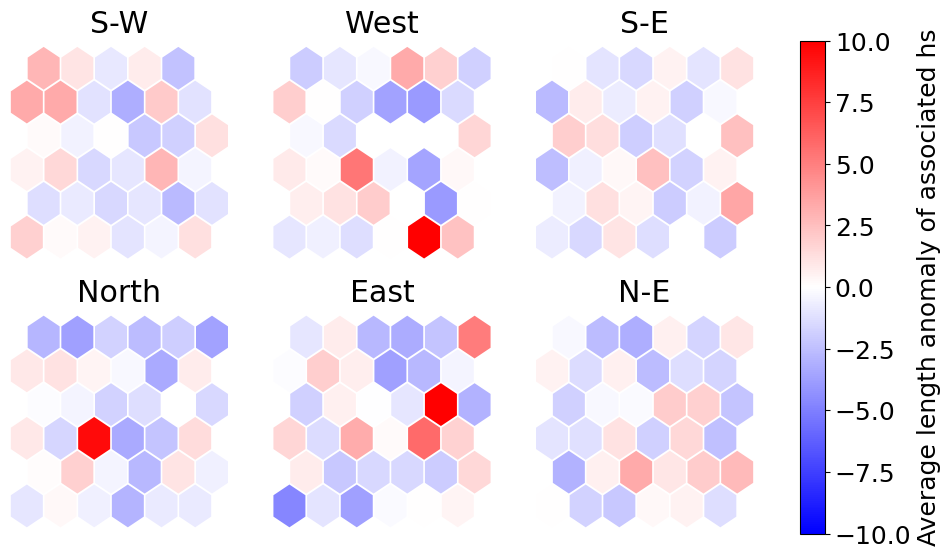

In [ ]:
kwargs = {
    "cmap": "bwr",
    "norm": Normalize(-10, 10),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, list_of_nodes) in enumerate(clustered_hotspells.items()):
    ax = axes[k]
    tplt = [np.mean([hs_info[0] for hs_info in l]) for l in list_of_nodes]
    fig, ax = net.plot_on_map(
        tplt - np.nanmean([len(l) for l in hotspells[k]]),
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Average length anomaly of associated hs")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')
